# 1 - Testing Difffraction Vector Overlaps

This notebook creates a bulk of the simulated data for the Toy model section of the paper.

Here we test overlaps in Diffraction Vectors with increasing overlaps

Carter Francis | csfrancis@wisc.edu | 2024-01-15

In [1]:
import numpy as np
from scipy.ndimage import correlate1d, correlate, gaussian_filter, median_filter
from skimage.feature.template import match_template
from skimage.draw import disk
import matplotlib.pyplot as plt

from orix.crystal_map import Phase
from orix.quaternion import Rotation
import hyperspy.api as hs

In [2]:
from scipy.spatial.transform import Rotation as R

In [3]:
from utils import *
import matplotlib.pyplot as plt
from skimage.feature import match_template
from skimage.morphology import disk as d2
from skimage.feature import peak_local_max
from scipy.ndimage import correlate
from skimage.util import view_as_windows

In [4]:
def _window_mode_2d(image, window_shape):
    windows = view_as_windows(image,window_shape)
    return windows

## 1.0 Diffraction Vectors with Increasing Ovverlaps

This is just a simple test that I did to show how template matching will start to break down in cases where there are two disks that are two different intensities.  This is something that would be good for someone to continue looking into!  Honestly there are quite a few gains in recall which could come from a better method for finding peaks.  

There is a realvent paper:

> Pekin, T. C., Gammer, C., Ciston, J., Minor, A. M., & Ophus, C. (2017). Optimizing disk registration algorithms for nanobeam electron diffraction strain mapping. Ultramicroscopy, 176, 170–176. https://doi.org/10.1016/j.ultramic.2016.12.021

which does a decent job of exploring this but they don't explore normalized cross correlations which we've found to be much better than other methods so this should really be revisited, especially with the advent of Neural Networks as well...

array([[20, 15]])

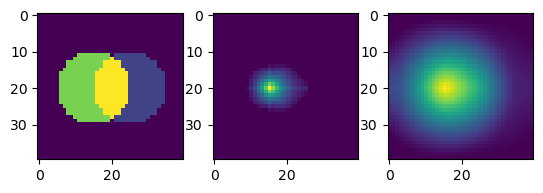

In [5]:
img = np.zeros((40,40))
img = add_disk(img, center=(20,15), radius=10, intensity=4)
img = add_disk(img, center=(20,25), radius=10, intensity=1)
fig, axs = plt.subplots(1,3)
axs[0].imshow(img)
d = d2(10)
temp = match_template(img,d,  pad_input=True)
axs[1].imshow(temp, vmin=0.2)
axs[2].imshow(correlate(img/np.mean(img),d/np.mean(d)))
peak_local_max(temp,threshold_rel=0.2)

## Visually Inspecting the data

You can try increasing the num_crystals to see how things break down.

In [6]:
Al_Structure = Phase.from_cif("data/Al.cif")

In [7]:
from dask_image.ndfilters import gaussian_filter

s = CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=40)
arr = s.make_4d_nano(num_electrons=10)
ground_truth_vectors = s.vectors
from skimage.draw import disk
mask = np.ones((64,64), dtype=bool)
rr,cc = disk((32,32), 10)
mask[rr,cc]=False
print(np.sum(arr[:,:, mask])/(256 * 256), "Average Electrons per Frame")
signal = hs.signals.Signal2D(arr)
signal.set_signal_type("electron_diffraction")
signal = signal.as_lazy()

signal.rechunk((32,32))
filtered = signal.filter(gaussian_filter, 
             sigma=(1,1,0,0))
template = filtered.template_match_disk(disk_r=5,
                            subtract_min=False,
                                show_progressbar=False)
template.data[:,:,:, 0:5]=0
template.data[:,:,:,-5:]=0
template.data[:,:, 0:5, :]=0
template.data[:,:,-5:, :]=0
pks = template.find_peaks(threshold_abs=0.4, interactive=False,show_progressbar=False )
from pyxem.signals.diffraction_vectors import DiffractionVectors
vect = DiffractionVectors.from_peaks(pks, center= (32, 32),
                                         calibration=(1/32,1/32))
vect.compute()

/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:523: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


1559.337872465947 Average Electrons per Frame
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 60.45 ss


In [8]:
%matplotlib ipympl
signal.axes_manager.signal_axes[0].scale= 1/32
signal.axes_manager.signal_axes[1].scale= 1/32
signal.axes_manager.signal_axes[0].offset= -1
signal.axes_manager.signal_axes[1].offset= -1

m = vect.to_markers(sizes=(15,))


ground_truth_vectors = s.vectors
ground_truth_vectors = ground_truth_vectors[(ground_truth_vectors[:,2]**2+ground_truth_vectors[:,3]**2)**0.5>0.05]
ground_truth_vectors = ground_truth_vectors[(ground_truth_vectors[:,2]**2+ground_truth_vectors[:,3]**2)**0.5<0.8]
m2 = convert_flat_to_markers(ground_truth_vectors, signal)
m2 = hs.plot.markers.Points(offsets=m2.T, color="r")

signal.plot(vmax="94th")

signal.add_marker(m)
signal.add_marker(m2)

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 226.53 ms
[########################################] | 100% Completed | 213.24 ms


## Make the Diffraction Vector Recall Data

In [ ]:
import hyperspy.api as hs
from dask_image.ndfilters import gaussian_filter
hs.set_log_level("ERROR")
hs.preferences.General.show_progress_bar=False
for i in range(6):
    num_crystals = [40, 80, 120, 200, 400, 600, 1200]
    simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]
    with open("AllResults/recall"+str(i)+".txt","w+") as f:
        f.write("num_crystals, recall, false_positives \n")
        from skimage.draw import disk
        mask = np.ones((64,64), dtype=bool)
        rr,cc = disk((32,32), 10)
        mask[rr,cc]=False
        for s, num_crystal in zip(simulations,num_crystals):
            arr = s.make_4d_nano(num_electrons=10)
            ground_truth_vectors = s.vectors
            print(np.sum(arr[:,:, mask])/(256 * 256), "Average Electrons per Frame")
            signal = hs.signals.Signal2D(arr)
            signal.set_signal_type("electron_diffraction")
            signal = signal.as_lazy()
            signal.rechunk((32,32))
            filtered = signal.filter(gaussian_filter, 
                         sigma=(1,1,0,0))
            template = filtered.template_match_disk(disk_r=5,
                                        subtract_min=False,
                                            show_progressbar=False)
            template.data[:,:,:, 0:5]=0
            template.data[:,:,:,-5:]=0
            template.data[:,:, 0:5, :]=0
            template.data[:,:,-5:, :]=0
            pks = template.find_peaks(threshold_abs=0.4, interactive=False,show_progressbar=False )
            from pyxem.signals.diffraction_vectors import DiffractionVectors
            vect = DiffractionVectors.from_peaks(pks, center= (32, 32),
                                                     calibration=(1/32,1/32))
            vect.compute()
            filt = vect.filter_magnitude(.05,
                                         .8,
                                             show_progressbar=False )
            ground_truth_vectors = ground_truth_vectors[(ground_truth_vectors[:,2]**2+ground_truth_vectors[:,3]**2)**0.5>0.05]
            ground_truth_vectors = ground_truth_vectors[(ground_truth_vectors[:,2]**2+ground_truth_vectors[:,3]**2)**0.5<0.8]

            from scipy.spatial import KDTree
            flat = filt.flatten_diffraction_vectors()
            flat.data =  flat.data[np.logical_not(np.any(np.isnan(flat.data), axis=1))]
            ground_truth_vectors[:,2:4] = ground_truth_vectors[:,2:4]*32
            flat.data[:,2:] = flat.data[:,2:]*32
            gt_tree = KDTree(ground_truth_vectors[:,0:4])
            flat_tree = KDTree(flat.data)

            false_positives = [len(i) == 0 for i in gt_tree.query_ball_point(flat.data, r=9)]
            # is there a vector within 2 pixels?
            is_bigger = [len(i)>1 for i in flat_tree.query_ball_point(ground_truth_vectors[:,:4], r=2)]
            r = np.sum(is_bigger)/len(is_bigger)
            fp = np.sum(false_positives)/ len(false_positives)
            print("Recall ", r) 
            print("False Positives", fp)
            f.write(str(num_crystal)+", " + str(r)+", "+ str(fp)+"\n")

/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:523: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


1957.8807536216552 Average Electrons per Frame
[########################################] | 100% Completed | 62.91 ss
Recall  1.0
False Positives 0.021130968547992828
3498.5782846651086 Average Electrons per Frame
[########################################] | 100% Completed | 71.20 ss
Recall  0.9788328048675979
False Positives 0.01679241810820758
6276.000413019049 Average Electrons per Frame
[########################################] | 100% Completed | 67.05 ss
Recall  0.9820614553435759
False Positives 0.00856714005311165
9741.782272846758 Average Electrons per Frame
[########################################] | 100% Completed | 84.94 ss
Recall  0.9567203351334982
False Positives 0.006089654870995469
17635.939649064447 Average Electrons per Frame
[########################################] | 100% Completed | 94.92 ss
Recall  0.9519199170858718
False Positives 0.0028806839301201833
28013.020390538528 Average Electrons per Frame
[########################################] | 100% Completed |

/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:523: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


2100.623332986172 Average Electrons per Frame
[########################################] | 100% Completed | 67.31 ss
Recall  0.9475126764423736
False Positives 0.027108213055901532
3814.276705356083 Average Electrons per Frame
[########################################] | 100% Completed | 63.71 ss
Recall  0.9947478991596639
False Positives 0.01738670141292398
5424.254852696251 Average Electrons per Frame
[########################################] | 100% Completed | 65.36 ss
Recall  0.9913142471644811
False Positives 0.017889856383580233
9874.005227514672 Average Electrons per Frame
[########################################] | 100% Completed | 65.96 ss
Recall  0.9578991596638655
False Positives 0.007776198764111326
21810.392772556857 Average Electrons per Frame
[########################################] | 100% Completed | 88.85 ss
Recall  0.9544891947421839
False Positives 0.004010910907065197
30840.16976369497 Average Electrons per Frame
[########################################] | 100%

/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:523: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


2438.6862866660945 Average Electrons per Frame
[########################################] | 100% Completed | 53.96 ss
Recall  1.0
False Positives 0.03719696502374931
4717.424640781853 Average Electrons per Frame
[########################################] | 100% Completed | 58.33 ss
Recall  0.9864242424242424
False Positives 0.011282315775900973
5070.095689156413 Average Electrons per Frame
[########################################] | 100% Completed | 61.43 ss
Recall  0.9804171637799811
False Positives 0.016390065239784823
11683.995061561254 Average Electrons per Frame
[########################################] | 100% Completed | 73.65 ss
Recall  0.9754246562306704
False Positives 0.0059668597384795255
17295.11223368235 Average Electrons per Frame
[########################################] | 100% Completed | 72.12 ss
Recall  0.9641856964851895
False Positives 0.00706334824895529
31318.013688083876 Average Electrons per Frame
[########################################] | 100% Completed | 

/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:523: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


2381.4240466919073 Average Electrons per Frame
[########################################] | 100% Completed | 71.88 ss
Recall  0.9960556844547563
False Positives 0.02359720958447073
3123.10304133943 Average Electrons per Frame
[#################                       ] | 43% Completed | 23.08 sms

## Plotting Results

In [ ]:
recall = [np.loadtxt("AllResults/recall"+str(i)+".txt", delimiter=",", skiprows=1) for i in range(6)]
mean_recall = np.mean(recall, axis=0)
std_recall = np.std(recall, axis=0)

In [ ]:
num_crystals = [40, 80, 120, 200, 400, 600, 1200]
simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]

In [ ]:
fig = plt.figure(figsize=(5,5))

axs = fig.add_axes((.15,.15, 0.8,0.7))
axs.errorbar(mean_recall[:,0],
             mean_recall[:,1]*100,
             std_recall[:,1]*100,
             capsize=2, color="black",ls="none",
             marker="o", markersize=5
            )
axs.set_xlabel("Number of Crystals")
axs.set_ylabel("Recall Percentage")
top = axs.twiny()

top.set_xlim((400*40)/(256*256), (400*1200)/(256*256))
top.set_xlabel("Average Number of Crystals in Projection")
axs.set_ylim(60,104)
corners = [.2,.45,.7]

axs2 = fig.add_axes((.2,.2, 0.2,0.2))

axs3 = fig.add_axes((.45,.2, 0.2,0.2))

axs4 = fig.add_axes((.7,.2, 0.2,0.2))

for ax in [axs2,axs3,axs4]:
    ax.set_xticks([])
    ax.set_yticks([])
    
for a, i,c in zip([axs2, axs3, axs4], [0,4,6], corners):
    simulations[i].plot_real_space(ax=a, alpha=0.3)

    axs.annotate("", xy=(num_crystals[i],59.8), xytext=(c, .16), xycoords="data",
                 textcoords="figure fraction",
                 arrowprops=dict(facecolor='black',arrowstyle="-", lw=1.5),annotation_clip=False)
    axs.annotate("", xy=(num_crystals[i],59.8), xytext=(c+0.18, .16), xycoords="data",
                 textcoords="figure fraction",
                 arrowprops=dict(facecolor='black',arrowstyle="-", lw=1.5),annotation_clip=False)

fig.savefig("Figures/Figure4-RecallPercentageVsOverlap.png",bbox_inches="tight" )
plt.show()